In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.metrics import accuracy_score

# KLASIFIKACIJA Naivni Bajes

Za svaku supstancu postoji vise klasa koje mogu da se klasifikuju, stoga radice se klasifikacija svake supstance posebno

### UCITAVANJE I PREPROCESIRANJE PODATAKA
*deo koda uzet iz fajla za analizu podataka*

In [382]:
sirovi_podaci = pd.read_csv('drug_consumption.data')
sirovi_podaci #fale imena atributa

#procitano sa sajtu podataka 
kolone = ["ID", "Age", "Gender", "Education", "Country", "Ethnicity", 
            "Nscore", "Escore", "Oscore", "Ascore", "Cscore", "Impulsiveness", "SS", 
            "Alchocol", "Amphet", "Amyl", "Benzos", "Caff", "Canabis", "Choc", "Coke", "Crack", "Ecstasy", 
            "Heroin", "Ketamin", "LegalH", "LSD", "Meth", "Mushrooms", "Nicotine", "Semer", "VSA"]

sirovi_podaci = pd.read_csv('drug_consumption.data', names = kolone)

podaci = sirovi_podaci.copy()

#ID mi ne igra nikakvu ulogu svakako
podaci = podaci.drop('ID', axis = 1)


In [383]:
# posto imamo vise klasa koje ispitujemo, razdvajam podatke na atribute i na klase
podaci.head()

#izdvajanje atributa
atributi1 = podaci.columns
atributi1

atributi = []
for atribut in atributi1:
    if atribut == 'Alchocol':
        break
    atributi.append(atribut)
    
print(atributi, end = ', ')

['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsiveness', 'SS'], 

In [384]:
#izdvajanje klasa
klase = []
for atribut in atributi1:
    if atribut not in atributi:
        klase.append(atribut)
        
print(klase, end = ', ')
print()

# provera deljenja kolona
print(len(klase) + len(atributi) == len(podaci.columns))

['Alchocol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Canabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamin', 'LegalH', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA'], 
True


In [385]:
#skaliramo podatke, jer bajes prima samo pozitivne vrednosti...
def skaliraj_podatke(X):
    return (X - min(X))/(max(X) - min(X))

In [386]:
podaci_skalirano = podaci.copy()

for a in atributi:
    podaci_skalirano[a] = skaliraj_podatke(podaci_skalirano[a])
    
#provera uspesnosti skaliranja
for a in atributi:
    print(len(podaci_skalirano[a].unique()) == len(podaci[a].unique()), end = ", ")
    
#nismo izgubili podatke

True, True, True, True, True, True, True, True, True, True, True, True, 

In [387]:
for x in klase:
    podaci_skalirano = podaci_skalirano.drop(x, axis = 1)
podaci_skalirano

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS
0,0.409137,1.0,0.537681,1.000000,0.409061,0.560562,0.412116,0.435690,0.367654,0.499040,0.428474,0.224398
1,0.246475,0.0,1.000000,1.000000,0.262143,0.413474,0.796106,0.762567,0.609827,0.479394,0.337920,0.465658
2,0.409137,0.0,0.537681,1.000000,0.262143,0.444788,0.622976,0.392939,0.266061,0.353580,0.215401,0.619957
3,0.000000,1.0,0.814329,1.000000,0.262143,0.492045,0.376883,0.527023,0.585213,0.584415,0.215401,0.224398
4,0.409137,1.0,1.000000,1.000000,0.262143,0.623275,0.250544,0.456995,0.456454,0.688508,0.428474,0.465658
...,...,...,...,...,...,...,...,...,...,...,...,...
1880,0.000000,1.0,0.412820,0.000000,0.262143,0.336890,0.765875,0.835399,0.609827,0.335773,0.629735,1.000000
1881,0.000000,0.0,0.412820,0.000000,0.262143,0.477550,0.765875,0.624600,0.609827,0.280854,0.629735,0.710933
1882,0.246475,1.0,0.653938,0.000000,0.262143,0.682246,0.289795,0.323599,0.244253,0.300104,0.565343,0.388117
1883,0.000000,1.0,0.412820,0.000000,0.262143,0.649318,0.206510,0.577652,0.266061,0.128634,0.705068,0.825752


In [388]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.model_selection import GridSearchCV

# POMOCNA FJA ZA GRAFICKI PRIKAZ, kod uzet sa vezbi
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.metrics import classification_report_imbalanced
from termcolor import colored, cprint


def report_imbalanced(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report_imbalanced(y, y_pred, zero_division=True))
    print("---------------------------------------------------------------------------------")
    
#     vrste = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
    kolone = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns = kolone, index = kolone))
    print("---------------------------------------------------------------------------------")

def report(model, x, y, text = "trening", ):
    y_pred = model.predict(x)
    
    print(colored('\t' + f'Klasifikacioni izveštaj za model {type(model).__name__} nad {text} podacima', 'blue', attrs= ['bold']))
    cprint('----------------------------------------------------------------------------------------------', attrs= ['bold'])
    cprint(classification_report(y, y_pred), attrs= ['dark']) 
    cprint('----------------------------------------------------------------------------------------------', attrs= ['bold'])

In [389]:
X, y = podaci_skalirano, podaci['Alchocol']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 42)

In [390]:
bajes = GaussianNB()

In [391]:
bajes.fit(X_train, y_train)

GaussianNB()

In [392]:
report_imbalanced(bajes, X_train, y_train)

Classification report for model GaussianNB on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        CL0       0.13      0.17      0.98      0.15      0.40      0.15        24
        CL1       0.10      0.04      0.99      0.06      0.20      0.04        24
        CL2       1.00      0.00      1.00      0.00      0.00      0.00        48
        CL3       0.27      0.17      0.95      0.21      0.40      0.15       138
        CL4       0.30      0.03      0.99      0.06      0.19      0.03       201
        CL5       0.46      0.59      0.54      0.52      0.56      0.32       531
        CL6       0.35      0.50      0.67      0.41      0.58      0.33       353

avg / total       0.40      0.40      0.72      0.35      0.46      0.24      1319

---------------------------------------------------------------------------------
Confusion matrix for model

In [393]:
report_imbalanced(bajes, X_test, y_test)

Classification report for model GaussianNB on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        CL0       0.00      0.00      0.99      0.00      0.00      0.00        10
        CL1       0.00      0.00      0.99      0.00      0.00      0.00        10
        CL2       1.00      0.00      1.00      0.00      0.00      0.00        20
        CL3       0.17      0.08      0.95      0.11      0.28      0.07        60
        CL4       0.07      0.01      0.97      0.02      0.11      0.01        86
        CL5       0.44      0.57      0.51      0.50      0.54      0.29       228
        CL6       0.30      0.43      0.64      0.35      0.52      0.27       152

avg / total       0.32      0.35      0.70      0.31      0.40      0.20       566

---------------------------------------------------------------------------------
Confusion matrix for model

In [394]:
n = len(klase)
preciznosti = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(podaci_skalirano, podaci[klase[i]], test_size = 0.30,  random_state = 42)
    bajes.fit(X_train, y_train)
    print(klase[i])
    report(bajes, X_test, y_test, text= 'test')
    
    predicted = bajes.predict(X_test)
    preciznosti.append(accuracy_score(y_test, predicted))

Alchocol
	Klasifikacioni izveštaj za model GaussianNB nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00        11
         CL1       0.00      0.00      0.00        11
         CL2       0.00      0.00      0.00        24
         CL3       0.28      0.12      0.16        60
         CL4       0.08      0.01      0.02        96
         CL5       0.45      0.43      0.44       229
         CL6       0.30      0.64      0.40       135

    accuracy                           0.34       566
   macro avg       0.16      0.17      0.15       566
weighted avg       0.30      0.34      0.29       566

----------------------------------------------------------------------------------------------
Amphet
	Klasifikacioni izveštaj za model GaussianNB nad test podacima
-----------------------------------------------------------------------

              precision    recall  f1-score   support

         CL0       0.85      0.71      0.77       433
         CL1       0.40      0.03      0.06        59
         CL2       0.16      0.21      0.18        39
         CL3       0.00      0.00      0.00        22
         CL4       0.00      0.00      0.00         2
         CL5       0.03      0.44      0.06         9
         CL6       0.00      0.00      0.00         2

    accuracy                           0.57       566
   macro avg       0.21      0.20      0.15       566
weighted avg       0.70      0.57      0.61       566

----------------------------------------------------------------------------------------------


/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packa

In [395]:
preciznosti_bajes = [round(x, 4) for x in preciznosti]

# pokusavam da dodam atribute koristeci i ostale klase

In [396]:
podaci_skalirano = podaci.copy()

n = len(podaci_skalirano['Heroin'])
    
for x in klase:
    for i in range(n):
        podaci_skalirano[x][i] = int(podaci_skalirano[x][i].strip('CL'))
    print(podaci_skalirano[x].unique())
        
# treba mi za klasifikaciju
for x in klase:
    podaci_skalirano[x] = podaci_skalirano[x].astype('float64')

podaci_skalirano

/tmp/ipykernel_5164/1481521344.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  podaci_skalirano[x][i] = int(podaci_skalirano[x][i].strip('CL'))


[5 6 4 2 1 0 3]
[2 0 1 3 5 4 6]
[0 2 1 3 5 4 6]
[2 0 3 1 4 5 6]
[6 5 4 3 0 1 2]
[0 4 3 2 1 6 5]
[5 6 4 0 3 2 1]
[0 3 2 1 6 5 4]
[0 1 2 3 5 4 6]
[0 4 1 3 2 6 5]
[0 1 2 3 5 6 4]
[0 2 3 1 5 4 6]
[0 1 2 3 5 4 6]
[0 2 1 3 4 5 6]
[0 3 1 6 4 2 5]
[0 1 2 3 4 5 6]
[2 4 0 6 1 3 5]
[0 2 3 4 1]
[0 1 3 6 2 5 4]


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamin,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,4.0,0.0,2.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,1.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,5.0
1881,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,2.0,0.0,0.0,3.0,5.0,4.0,4.0,5.0,0.0,0.0
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,4.0,0.0,2.0,0.0,2.0,0.0,2.0,6.0,0.0,0.0
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,3.0,0.0,0.0,3.0,3.0,0.0,3.0,4.0,0.0,0.0


In [397]:
#skaliram podatke
for a in atributi:
    podaci_skalirano[a] = skaliraj_podatke(podaci_skalirano[a])
for a in klase:
    podaci_skalirano[a] = skaliraj_podatke(podaci_skalirano[a])
podaci_skalirano.describe()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamin,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,...,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.278405,0.499735,0.550215,0.604629,0.264556,0.514137,0.499975,0.530058,0.499965,0.499944,...,0.219010,0.062334,0.094872,0.225995,0.176923,0.137754,0.197878,0.533422,0.002387,0.072237
std,0.247867,0.500133,0.214936,0.457463,0.055146,0.148125,0.152332,0.161318,0.143957,0.143969,...,0.274595,0.172463,0.203336,0.298275,0.248517,0.274439,0.244390,0.402322,0.039833,0.160396
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.412820,0.000000,0.262143,0.413474,0.393845,0.413998,0.412490,0.405822,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000
50%,0.246475,0.000000,0.537681,1.000000,0.262143,0.520448,0.500507,0.527023,0.497505,0.499040,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
75%,0.409137,1.000000,0.653938,1.000000,0.262143,0.607577,0.597404,0.647268,0.609827,0.584415,...,0.500000,0.000000,0.000000,0.500000,0.333333,0.000000,0.333333,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [398]:
#pravi skupove podataka pojedinacno bez svake klase
podaci_bez_klase = []
for x in klase:
    podaci_bez_klase.append(podaci_skalirano.drop(x, axis = 1))
    
#klasni_podaci, isto to
klasni_podaci = []
n = len(klase)
for i in range(n):
    klasni_podaci.append(podaci[klase[i]])
    
len(podaci_bez_klase)

19

In [399]:
#delimo podatke na train/test skupove
n = len(podaci_bez_klase)
preciznosti_sve = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(podaci_bez_klase[i], klasni_podaci[i], test_size = 0.30,  random_state = 42)

    bajes.fit(X_train, y_train)
    print(klase[i])
    report(bajes, X_test, y_test, text= 'test')
    
    predicted = bajes.predict(X_test)
    preciznosti_sve.append(round(accuracy_score(y_test, predicted), 4))


Alchocol
	Klasifikacioni izveštaj za model GaussianNB nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.04      0.82      0.07        11
         CL1       0.00      0.00      0.00        11
         CL2       0.14      0.33      0.20        24
         CL3       0.12      0.43      0.19        60
         CL4       0.00      0.00      0.00        96
         CL5       0.00      0.00      0.00       229
         CL6       0.40      0.01      0.03       135

    accuracy                           0.08       566
   macro avg       0.10      0.23      0.07       566
weighted avg       0.11      0.08      0.04       566

----------------------------------------------------------------------------------------------
Amphet
	Klasifikacioni izveštaj za model GaussianNB nad test podacima
-----------------------------------------------------------------------

Heroin
	Klasifikacioni izveštaj za model GaussianNB nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.99      0.49      0.65       481
         CL1       0.08      0.80      0.15        15
         CL2       1.00      0.03      0.06        30
         CL3       0.12      0.21      0.15        24
         CL4       0.02      0.11      0.04         9
         CL5       0.00      0.00      0.00         4
         CL6       0.02      0.67      0.04         3

    accuracy                           0.45       566
   macro avg       0.32      0.33      0.16       566
weighted avg       0.90      0.45      0.57       566

----------------------------------------------------------------------------------------------
Ketamin
	Klasifikacioni izveštaj za model GaussianNB nad test podacima
------------------------------------------------------------------------

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packa

              precision    recall  f1-score   support

         CL0       0.98      0.29      0.45       433
         CL1       0.16      0.56      0.24        59
         CL2       0.21      0.08      0.11        39
         CL3       0.00      0.00      0.00        22
         CL4       0.00      0.00      0.00         2
         CL5       0.06      0.22      0.09         9
         CL6       0.00      0.00      0.00         2

    accuracy                           0.29       566
   macro avg       0.20      0.16      0.13       566
weighted avg       0.78      0.29      0.38       566

----------------------------------------------------------------------------------------------


In [400]:
preciznosti_sve

[0.0795,
 0.2491,
 0.2032,
 0.4382,
 0.0353,
 0.311,
 0.0283,
 0.4134,
 0.4647,
 0.3799,
 0.4523,
 0.2438,
 0.5071,
 0.5159,
 0.4276,
 0.4929,
 0.3198,
 0.9947,
 0.2898]

# Kateogircki Bajes

In [401]:
podaci_skalirano

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamin,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,0.409137,1.0,0.537681,1.000000,0.409061,0.560562,0.412116,0.435690,0.367654,0.499040,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.000000
1,0.246475,0.0,1.000000,1.000000,0.262143,0.413474,0.796106,0.762567,0.609827,0.479394,...,0.666667,0.0,0.333333,0.000000,0.333333,0.500000,0.000000,0.666667,0.0,0.000000
2,0.409137,0.0,0.537681,1.000000,0.262143,0.444788,0.622976,0.392939,0.266061,0.353580,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.0,0.000000
3,0.000000,1.0,0.814329,1.000000,0.262143,0.492045,0.376883,0.527023,0.585213,0.584415,...,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.000000
4,0.409137,1.0,1.000000,1.000000,0.262143,0.623275,0.250544,0.456995,0.456454,0.688508,...,0.166667,0.0,0.000000,0.166667,0.000000,0.000000,0.333333,0.333333,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,0.000000,1.0,0.412820,0.000000,0.262143,0.336890,0.765875,0.835399,0.609827,0.335773,...,0.000000,0.0,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.0,0.833333
1881,0.000000,0.0,0.412820,0.000000,0.262143,0.477550,0.765875,0.624600,0.609827,0.280854,...,0.333333,0.0,0.000000,0.500000,0.833333,0.666667,0.666667,0.833333,0.0,0.000000
1882,0.246475,1.0,0.653938,0.000000,0.262143,0.682246,0.289795,0.323599,0.244253,0.300104,...,0.666667,0.0,0.333333,0.000000,0.333333,0.000000,0.333333,1.000000,0.0,0.000000
1883,0.000000,1.0,0.412820,0.000000,0.262143,0.649318,0.206510,0.577652,0.266061,0.128634,...,0.500000,0.0,0.000000,0.500000,0.500000,0.000000,0.500000,0.666667,0.0,0.000000


In [402]:
podaci_skalirano = podaci.copy()

for a in atributi:
    podaci_skalirano[a] = skaliraj_podatke(podaci_skalirano[a])
    
#provera uspesnosti skaliranja
for a in atributi:
    print(len(podaci_skalirano[a].unique()) == len(podaci[a].unique()), end = ", ")
    
#nismo izgubili podatke

True, True, True, True, True, True, True, True, True, True, True, True, 

In [403]:
for x in klase:
    podaci_skalirano = podaci_skalirano.drop(x, axis = 1)
podaci_skalirano

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS
0,0.409137,1.0,0.537681,1.000000,0.409061,0.560562,0.412116,0.435690,0.367654,0.499040,0.428474,0.224398
1,0.246475,0.0,1.000000,1.000000,0.262143,0.413474,0.796106,0.762567,0.609827,0.479394,0.337920,0.465658
2,0.409137,0.0,0.537681,1.000000,0.262143,0.444788,0.622976,0.392939,0.266061,0.353580,0.215401,0.619957
3,0.000000,1.0,0.814329,1.000000,0.262143,0.492045,0.376883,0.527023,0.585213,0.584415,0.215401,0.224398
4,0.409137,1.0,1.000000,1.000000,0.262143,0.623275,0.250544,0.456995,0.456454,0.688508,0.428474,0.465658
...,...,...,...,...,...,...,...,...,...,...,...,...
1880,0.000000,1.0,0.412820,0.000000,0.262143,0.336890,0.765875,0.835399,0.609827,0.335773,0.629735,1.000000
1881,0.000000,0.0,0.412820,0.000000,0.262143,0.477550,0.765875,0.624600,0.609827,0.280854,0.629735,0.710933
1882,0.246475,1.0,0.653938,0.000000,0.262143,0.682246,0.289795,0.323599,0.244253,0.300104,0.565343,0.388117
1883,0.000000,1.0,0.412820,0.000000,0.262143,0.649318,0.206510,0.577652,0.266061,0.128634,0.705068,0.825752


In [404]:
X, y = podaci_skalirano, podaci['Alchocol']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 42)

In [405]:
cnb = Pipeline([
    ('model', CategoricalNB())
])

In [406]:
cnb.fit(X_train, y_train)

Pipeline(steps=[('model', CategoricalNB())])

In [407]:
report_imbalanced(cnb, X_test, y_test)

Classification report for model Pipeline on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        CL0       1.00      0.00      1.00      0.00      0.00      0.00        10
        CL1       1.00      0.00      1.00      0.00      0.00      0.00        10
        CL2       1.00      0.00      1.00      0.00      0.00      0.00        20
        CL3       0.00      0.00      1.00      0.00      0.00      0.00        60
        CL4       1.00      0.00      1.00      0.00      0.00      0.00        86
        CL5       0.40      0.99      0.02      0.57      0.13      0.02       228
        CL6       0.29      0.01      0.99      0.03      0.11      0.01       152

avg / total       0.46      0.40      0.60      0.24      0.08      0.01       566

---------------------------------------------------------------------------------
Confusion matrix for model P

In [408]:
model = cnb.named_steps['model']

In [409]:
def plot_predicted_probabilities(pipeline, X_test, title):
    predicts = pipeline.predict_proba(X_test)
    klase = model.classes_

    fig, ax = plt.subplots()
    ax.bar(klase, np.max(predicts, axis=0))
    ax.grid(alpha=0.5)
    ax.set_xlabel('Class')
    ax.set_ylabel('Probability')
    ax.set_xticks(klase)
    plt.title(title)
    plt.show()

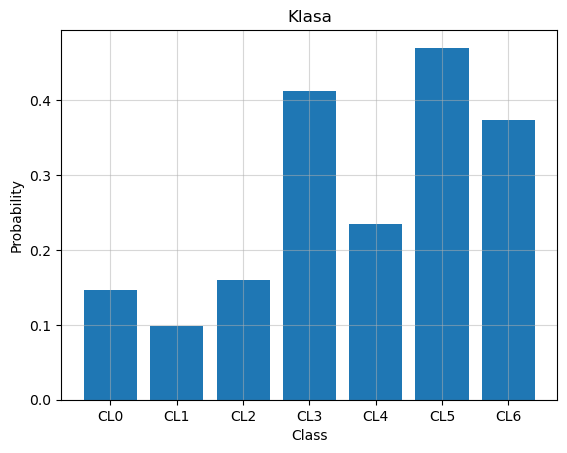

In [410]:
plot_predicted_probabilities(cnb, X_test, "Klasa")

In [411]:
# podesavanje parametara

In [412]:
parametri = {
    'model__alpha' : [0, 0.5, 1.0],
    'model__fit_prior' : [True, False]
}

In [413]:
parametrizovano = GridSearchCV(cnb, param_grid=parametri, scoring='accuracy', cv=3, verbose=4)

In [414]:
parametrizovano.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END model__alpha=0, model__fit_prior=True;, score=nan total time=   0.0s
[CV 2/3] END model__alpha=0, model__fit_prior=True;, score=nan total time=   0.0s
[CV 3/3] END model__alpha=0, model__fit_prior=True;, score=0.401 total time=   0.0s
[CV 1/3] END model__alpha=0, model__fit_prior=False;, score=nan total time=   0.0s
[CV 2/3] END model__alpha=0, model__fit_prior=False;, score=nan total time=   0.0s
[CV 3/3] END model__alpha=0, model__fit_prior=False;, score=0.048 total time=   0.0s
[CV 1/3] END model__alpha=0.5, model__fit_prior=True;, score=nan total time=   0.0s
[CV 2/3] END model__alpha=0.5, model__fit_prior=True;, score=nan total time=   0.0s
[CV 3/3] END model__alpha=0.5, model__fit_prior=True;, score=0.403 total time=   0.0s
[CV 1/3] END model__alpha=0.5, model__fit_prior=False;, score=nan total time=   0.0s
[CV 2/3] END model__alpha=0.5, model__fit_prior=False;, score=nan total time=   0.0s
[CV 3/3] END mode

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dzzz/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._scor

GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', CategoricalNB())]),
             param_grid={'model__alpha': [0, 0.5, 1.0],
                         'model__fit_prior': [True, False]},
             scoring='accuracy', verbose=4)

In [415]:
najbolji_parametri = parametrizovano.best_params_
najbolji_parametri

{'model__alpha': 0, 'model__fit_prior': True}

In [416]:
kategoricki_bajes = parametrizovano.best_estimator_

In [417]:
kategoricki_bajes.fit(X_train, y_train)
report_imbalanced(kategoricki_bajes, X_test, y_test)

Classification report for model Pipeline on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        CL0       1.00      0.00      1.00      0.00      0.00      0.00        10
        CL1       1.00      0.00      1.00      0.00      0.00      0.00        10
        CL2       1.00      0.00      1.00      0.00      0.00      0.00        20
        CL3       0.00      0.00      1.00      0.00      0.00      0.00        60
        CL4       1.00      0.00      1.00      0.00      0.00      0.00        86
        CL5       0.40      0.99      0.02      0.57      0.13      0.02       228
        CL6       0.25      0.01      0.99      0.03      0.11      0.01       152

avg / total       0.45      0.40      0.60      0.24      0.08      0.01       566

---------------------------------------------------------------------------------
Confusion matrix for model P

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


In [418]:
n = len(klase)
preciznosti_kategoricki = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(podaci_skalirano, podaci[klase[i]], test_size = 0.30,  random_state = 42)
    kategoricki_bajes.fit(X_train, y_train)
    print(klase[i])
#     report(kategoricki_bajes, X_test, y_test, text= 'test')
    
    predicted = kategoricki_bajes.predict(X_test)
    preciznosti_kategoricki.append(round(accuracy_score(y_test, predicted), 4))

Alchocol
Amphet
Amyl
Benzos
Caff
Canabis
Choc
Coke
Crack
Ecstasy
Heroin
Ketamin
LegalH
LSD
Meth
Mushrooms
Nicotine
Semer
VSA


/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:

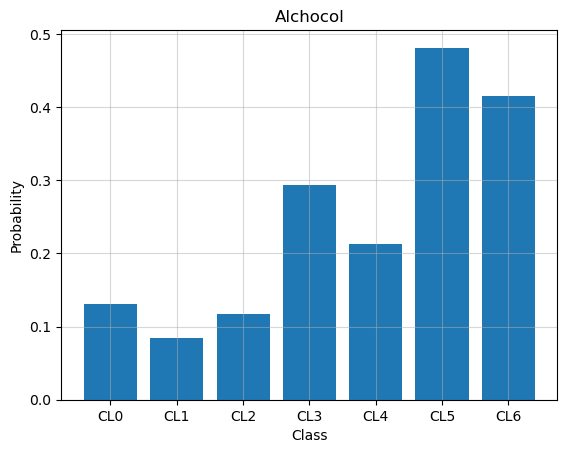

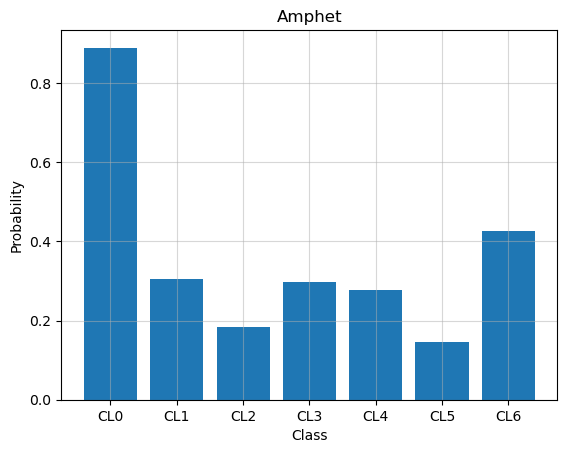

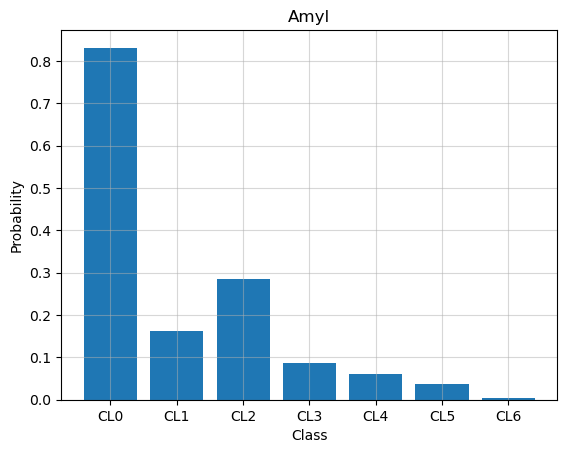

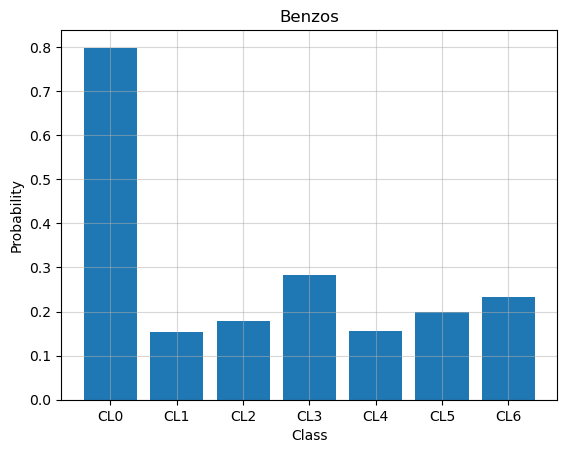

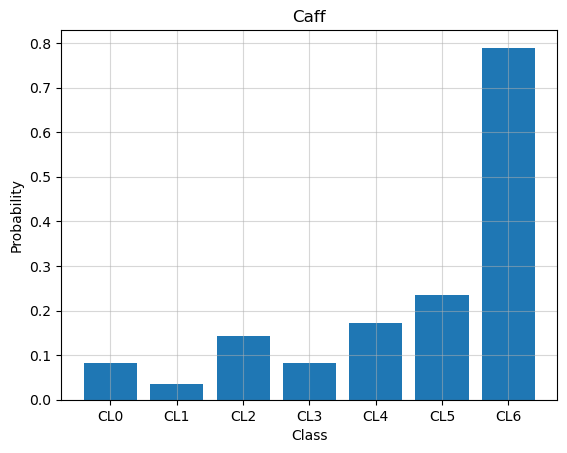

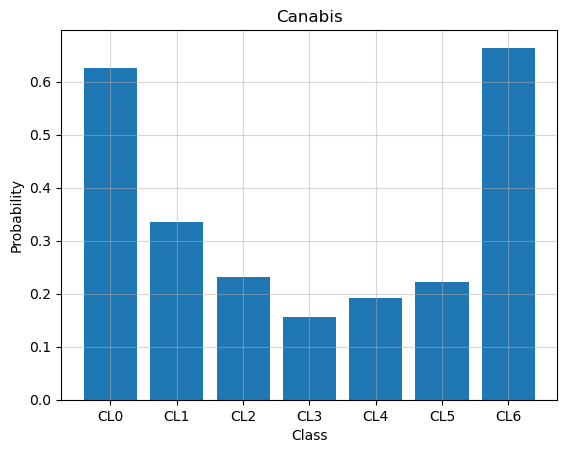

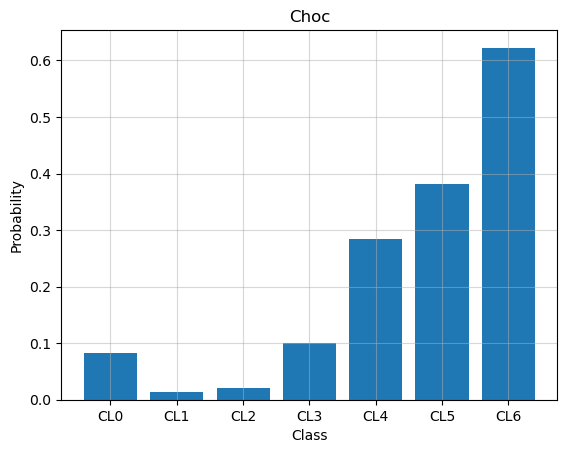

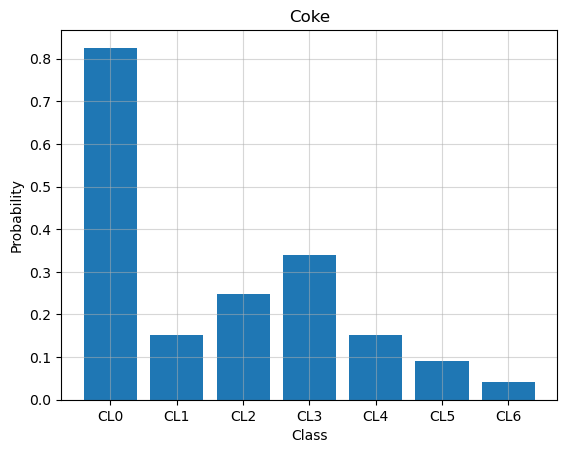

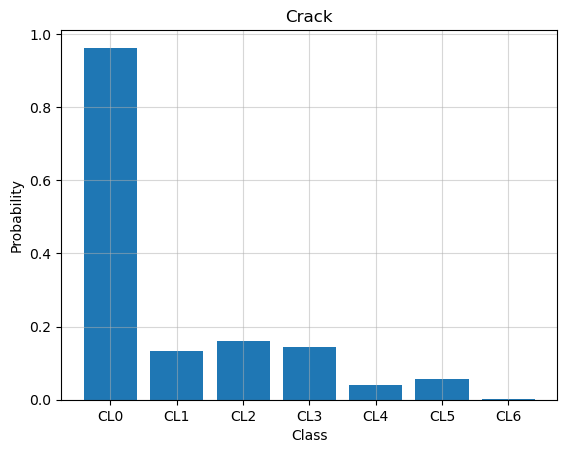

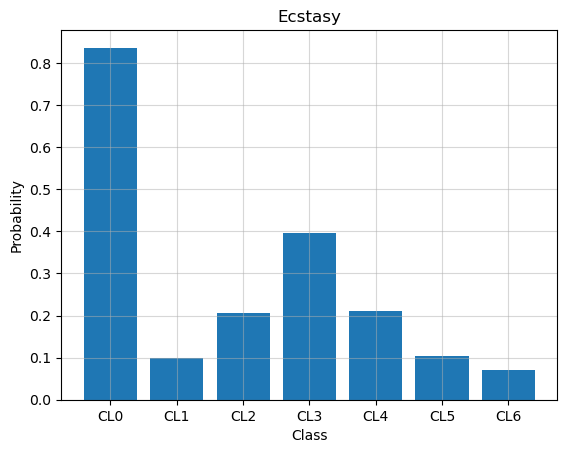

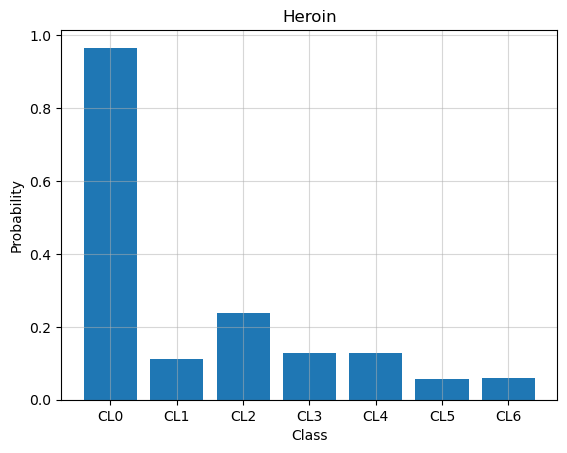

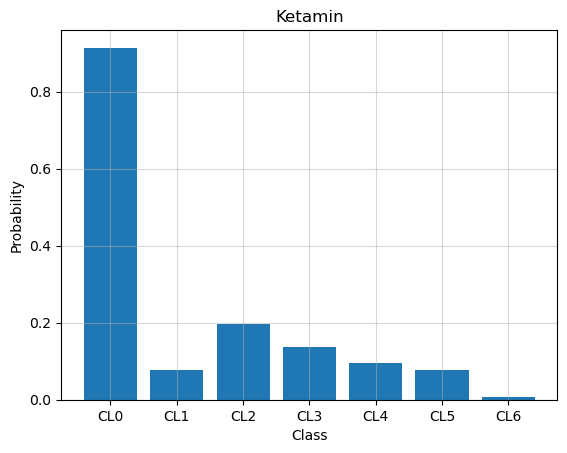

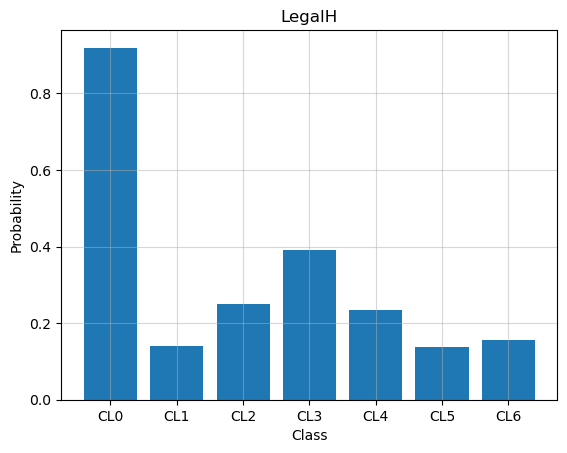

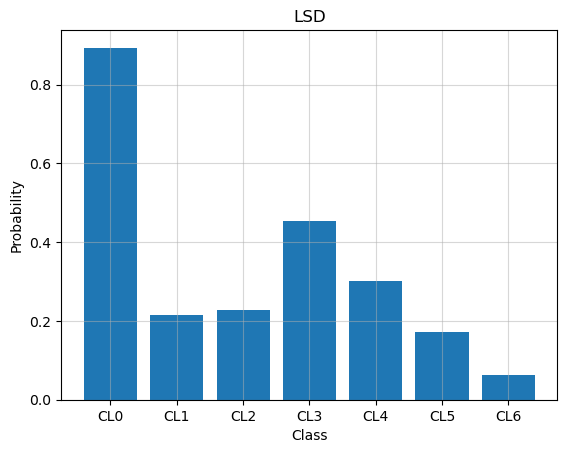

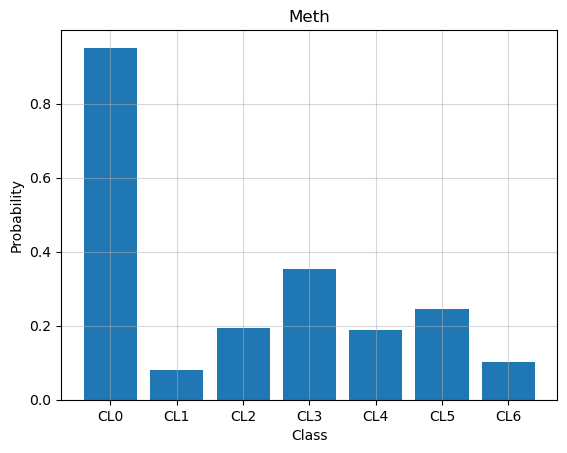

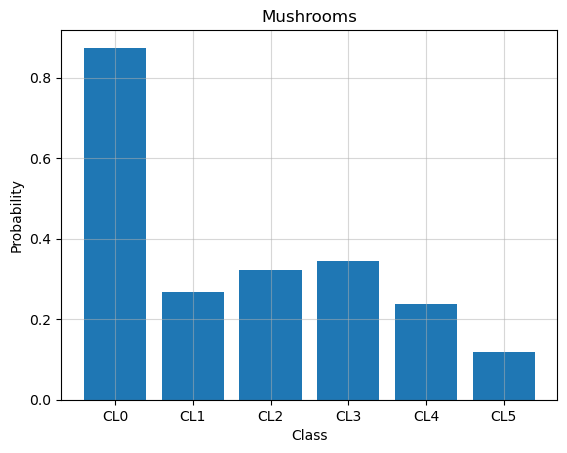

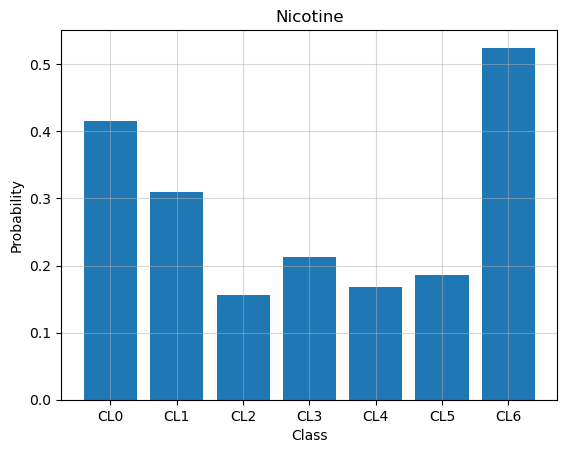

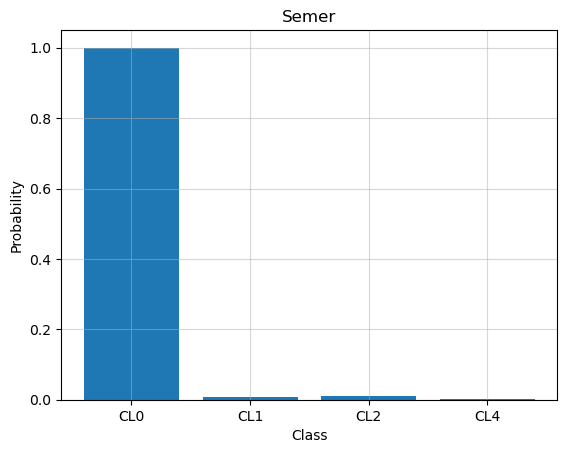

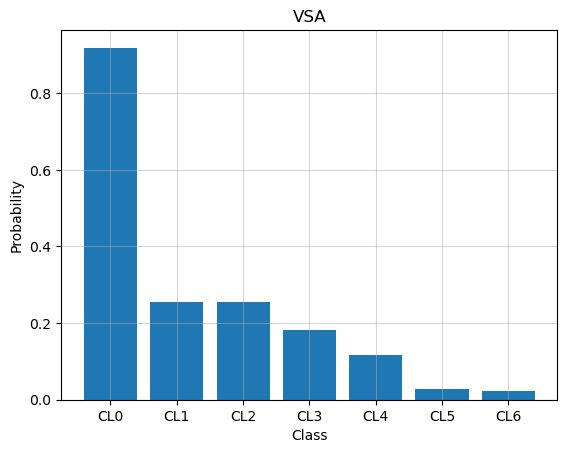

In [419]:
i = 0
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(podaci_skalirano, podaci[klase[i]], test_size = 0.30,  random_state = 42)
    cnb.fit(X_train, y_train)
    plot_predicted_probabilities(cnb, X_test, title = klase[i])

In [420]:
preciznosti_kategoricki #preciznosti_bajes, #preciznosti_sve

[0.3922,
 0.5247,
 0.6908,
 0.5406,
 0.735,
 0.4011,
 0.424,
 0.5548,
 0.8693,
 0.53,
 0.8498,
 0.7915,
 0.5919,
 0.5565,
 0.7456,
 0.5247,
 0.3816,
 0.9947,
 0.765]

In [421]:
# pokusavam da dodam atribute koristeci i ostale klase

In [422]:
podaci_skalirano = podaci.copy()

n = len(podaci_skalirano['Heroin'])
    
for x in klase:
    for i in range(n):
        podaci_skalirano[x][i] = int(podaci_skalirano[x][i].strip('CL'))
    print(podaci_skalirano[x].unique())
        
# treba mi za klasifikaciju
for x in klase:
    podaci_skalirano[x] = podaci_skalirano[x].astype('float64')

podaci_skalirano

/tmp/ipykernel_5164/1481521344.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  podaci_skalirano[x][i] = int(podaci_skalirano[x][i].strip('CL'))


[5 6 4 2 1 0 3]
[2 0 1 3 5 4 6]
[0 2 1 3 5 4 6]
[2 0 3 1 4 5 6]
[6 5 4 3 0 1 2]
[0 4 3 2 1 6 5]
[5 6 4 0 3 2 1]
[0 3 2 1 6 5 4]
[0 1 2 3 5 4 6]
[0 4 1 3 2 6 5]
[0 1 2 3 5 6 4]
[0 2 3 1 5 4 6]
[0 1 2 3 5 4 6]
[0 2 1 3 4 5 6]
[0 3 1 6 4 2 5]
[0 1 2 3 4 5 6]
[2 4 0 6 1 3 5]
[0 2 3 4 1]
[0 1 3 6 2 5 4]


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamin,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,4.0,0.0,2.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,1.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,5.0
1881,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,2.0,0.0,0.0,3.0,5.0,4.0,4.0,5.0,0.0,0.0
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,4.0,0.0,2.0,0.0,2.0,0.0,2.0,6.0,0.0,0.0
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,3.0,0.0,0.0,3.0,3.0,0.0,3.0,4.0,0.0,0.0


In [423]:
#skaliram podatke
for a in atributi:
    podaci_skalirano[a] = skaliraj_podatke(podaci_skalirano[a])
for a in klase:
    podaci_skalirano[a] = skaliraj_podatke(podaci_skalirano[a])
podaci_skalirano.describe()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamin,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,...,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.278405,0.499735,0.550215,0.604629,0.264556,0.514137,0.499975,0.530058,0.499965,0.499944,...,0.219010,0.062334,0.094872,0.225995,0.176923,0.137754,0.197878,0.533422,0.002387,0.072237
std,0.247867,0.500133,0.214936,0.457463,0.055146,0.148125,0.152332,0.161318,0.143957,0.143969,...,0.274595,0.172463,0.203336,0.298275,0.248517,0.274439,0.244390,0.402322,0.039833,0.160396
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.412820,0.000000,0.262143,0.413474,0.393845,0.413998,0.412490,0.405822,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000
50%,0.246475,0.000000,0.537681,1.000000,0.262143,0.520448,0.500507,0.527023,0.497505,0.499040,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
75%,0.409137,1.000000,0.653938,1.000000,0.262143,0.607577,0.597404,0.647268,0.609827,0.584415,...,0.500000,0.000000,0.000000,0.500000,0.333333,0.000000,0.333333,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [424]:
#pravi skupove podataka pojedinacno bez svake klase
podaci_bez_klase = []
for x in klase:
    podaci_bez_klase.append(podaci_skalirano.drop(x, axis = 1))
    
#klasni_podaci, isto to
klasni_podaci = []
n = len(klase)
for i in range(n):
    klasni_podaci.append(podaci[klase[i]])
    
len(podaci_bez_klase)

19

In [425]:
klasni_podaci[0]

0       CL5
1       CL5
2       CL6
3       CL4
4       CL4
       ... 
1880    CL5
1881    CL5
1882    CL4
1883    CL5
1884    CL4
Name: Alchocol, Length: 1885, dtype: object

In [426]:
#delimo podatke na train/test skupove
n = len(podaci_bez_klase)
preciznosti_sve_kategoricki = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(podaci_bez_klase[i], klasni_podaci[i], test_size = 0.30,  random_state = 42)

    kategoricki_bajes.fit(X_train, y_train)
    print(klase[i])
    report(kategoricki_bajes, X_test, y_test, text= 'test')
    
    predicted = kategoricki_bajes.predict(X_test)
    preciznosti_sve.append(round(accuracy_score(y_test, predicted), 4))

Alchocol


/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1